In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.linalg import cholesky, solve_triangular


My implementation for the heat equation using just analytical solutions of the derivatives had some issues. I will try to implement the heat equation into the kernel using jax.    
The heat equation in one dimension is given by:
$$\frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} = f(x,t)$$
where $\alpha$ is the thermal diffusivity. I took the analytical solution from the paper [Raissi](https://www.sciencedirect.com/science/article/pii/S0021999117305582?via%3Dihub) and I try to reproduce the same results. One solution for $\alpha$ = 1 is given by:
\begin{equation}
\begin{aligned}
f(x,t) &= \exp{(-t)}(4 \pi - 1)\sin{(2\pi x)} \\     
u(x,t) &= \exp{(-t)}\sin{(2\pi x)}
\end{aligned}
\end{equation}
I will now sample some data from this solution and plot the data. I will add some gaussian noise to the data, mainly for stability reasons and to to simulate real world meassured data.

Text(0.5, 0, 'f(t,x)')

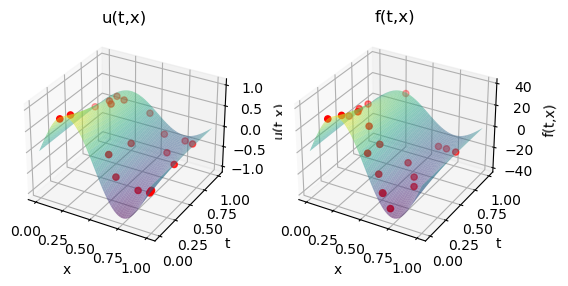

In [85]:
def get_data_set(n_training_points,noise):
    def f(t,x):
        return np.exp(-t)*np.sin(2*np.pi*x) *(4*np.pi**2 - 1)
    def u(t,x):
        return np.exp(-t)*np.sin(2*np.pi*x)
    
    #alpha = 2
    # def f(t, x):
    #     return np.exp(-t) * np.sin(2 * np.pi * x) * (8 * np.pi**2 - 1)

    # def u(t, x):
    #     return np.exp(-t) * np.sin(2 * np.pi * x)

    # create the training data u
    rng_u = np.random.default_rng(seed=123)
    t_u = rng_u.uniform(0,1,n_training_points).reshape(-1,1)
    x_u = rng_u.uniform(0,1,n_training_points).reshape(-1,1)
    #t_u = np.sort(t_u).reshape(-1,1)
    #x_u = np.sort(x_u).reshape(-1,1)
    u_values = u(t_u,x_u).reshape(-1,1) + np.random.normal(0, noise[0], u(t_u,x_u).shape)
    
    # create the training data f
    rng_f = np.random.default_rng(seed=20)
    t_f = rng_f.uniform(0,1,n_training_points).reshape(-1,1)
    x_f = rng_f.uniform(0,1,n_training_points).reshape(-1,1)
    #t_f = np.sort(t_f).reshape(-1,1)
    #x_f = np.sort(x_f).reshape(-1,1)
    f_values = f(t_f,x_f).reshape(-1,1) + np.random.normal(0, noise[1], u(t_u,x_u).shape)
    return u_values, f_values, t_u, x_u, t_f, x_f
noise = [0.0001,0.0001]
u_train, f_train, t_u, x_u, t_f, x_f = get_data_set(20,noise)
t = np.linspace(0,1,100)
x = np.linspace(0,1,100)
t_mesh, x_mesh = np.meshgrid(t,x)
u_mesh = np.exp(-t_mesh)*np.sin(2*np.pi*x_mesh)
f_mesh = np.exp(-t_mesh)*np.sin(2*np.pi*x_mesh) *(4*np.pi**2 - 1)

#plot the data in a 3d plot
fig, ax = plt.subplots(1,2,subplot_kw={"projection": "3d"})
ax[0].plot_surface(x_mesh, t_mesh, u_mesh, cmap='viridis', edgecolor='none', alpha=0.5)
ax[0].scatter(x_u, t_u, u_train, c='r', marker='o')
ax[0].set_title('u(t,x)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].set_zlabel('u(t,x)')
ax[1].plot_surface(x_mesh, t_mesh, f_mesh, cmap='viridis', edgecolor='none', alpha=0.5)
ax[1].scatter(x_f, t_f, f_train, c='r', marker='o')
ax[1].set_title('f(t,x)')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('f(t,x)')


The next step is to implement the kernel for the heat equation. I will use the same kernel as in the paper, so just the RBF kernel. Our linear operator is given by:
$$\mathcal{L}_x ^\alpha = \frac{\partial}{\partial t} - \alpha \frac{\partial^2}{\partial x^2}$$    
We need 4 different parts for the kernel:
1. The kernel without the linear operator $K(x,y,t,s)_{uu}$
2. The kernel with one $K_{uf}$ = $\mathcal{L}_{y}^\alpha$ $K_{uu}$
3. The kernel with one $K_{fu}$ = $\mathcal{L}_x^\alpha$ $K_{uu}$
4. And with both transformations $K_{ff}$ = $\mathcal{L}_x^\alpha$ $\mathcal{L}_y^\alpha$ $K_{uu}$
The first kernel is just the normal RBF kernel: 
\begin{align}
K(x,y,t,s)_{uu} = \sigma_f^2 e^{-\gamma_x(x-y)^2 - \gamma_t(t-s)^2}
\end{align}
For the second we use the linear operator once with respect to y and s.
\begin{align}
K_{uf} = \mathcal{L}_{y}^\alpha K_{uu} = \frac{\partial}{\partial s} K_{uu} - \alpha \frac{\partial^2}{\partial y^2} K_{uu}
\end{align}
Same for the third kernel, but with respect to x and t.
\begin{align}
K_{fu} = \mathcal{L}_{x}^\alpha K_{uu} = \frac{\partial}{\partial t} K_{uu} - \alpha \frac{\partial^2}{\partial x^2} K_{uu}
\end{align}
And for the last kernel we use the linear operator twice.
\begin{align}
K_{ff} = \mathcal{L}_{x}^\alpha \mathcal{L}_{y}^\alpha K_{uu} = \frac{\partial^2}{\partial t \partial s} K_{uu} + \alpha^2 \frac{\partial^2}{\partial x^2} \frac{\partial^2}{\partial y^2} K_{uu}
\end{align}
The implementation was very hard at the start, so I had to split the starting kernel into two parts, one for xy and one for ts. I just use the $\sigma_f$ parameter once in the x kernel. But I will multiply the two kernels anyways, so it should not make a difference.

In [117]:
@jit
def rbf_kernel_single_x(x, y, params):
    l, sigma_f_sq = params[0], params[1]
    sqdist = jnp.sum(x-y)**2
    return sigma_f_sq * jnp.exp(-0.5 / l**2 * sqdist)
@jit
def rbf_kernel_single_t(t, s, l_t):
    sqdist = jnp.sum(t-s)**2
    value = jnp.exp(-0.5 / l_t**2 * sqdist)
    return value

In [ ]:
def k_uu(X, Y, T, S, params):
    

In [119]:
@jit
def k_ff(X, Y, T, S, params):
    # params = [l_x, sigma_f_sq, l_t, alpha]
    alpha = params[-1]
    params = params[:-1]
    X,Y,T,S = X.flatten(), Y.flatten(), T.flatten(), S.flatten() #this is not my favourite solution, but it works atm. However there still is a problem with multidimesional data
    # first I vectorize both the kernel functions seperately
    vectorized_rbf_kernel_x = vmap(vmap(rbf_kernel_single_x, (None, 0, None)), (0, None, None))
    vectorized_rbf_kernel_t = vmap(vmap(rbf_kernel_single_t, (None, 0, None)), (0, None, None))
    # now I compute the derivatives seperately and then multiply by the other kernel. This should be reasonable, because the other kernel is not dependent on the derivative.
    dk_dtds = grad(grad(rbf_kernel_single_t, argnums = 1), argnums = 0)
    vectorized_dtds = vmap(vmap(dk_dtds, (None, 0, None)), (0, None, None))

    dk_dydy = grad(grad(rbf_kernel_single_x, argnums = 1), argnums = 1) # this is both the second derivative of the kernel with respect y
    dk_dxdxdydy = grad(grad(dk_dydy, argnums = 0), argnums = 0) # this is both the second derivative of the kernel with respect to x and y
    vectorized_dxdxdydy = vmap(vmap(dk_dxdxdydy, (None, 0, None)), (0, None, None))

    #first part of the kernel
    first_part = vectorized_dtds(T,S,params[2]) * vectorized_rbf_kernel_x(X,Y,params) 
    #second part of the kernel
    second_part = vectorized_dxdxdydy(X,Y,params) * vectorized_rbf_kernel_t(T,S,params[2]) 
    return first_part + alpha**2 * second_part

x = np.linspace(0,1,100).reshape(-1,1)
t = np.linspace(0,1,100).reshape(-1,1)
y = np.linspace(0,2,100).reshape(-1,1)
s = np.linspace(0,1,100).reshape(-1,1)
params = [1,1,1,1]
k_ff(x,y,t,s,params)

Array([[ 4.        ,  3.9964297 ,  3.9857306 , ..., -0.4766615 ,
        -0.4431623 , -0.410425  ],
       [ 3.9988775 ,  3.9991837 ,  3.9923518 , ..., -0.4951889 ,
        -0.46122506, -0.4279905 ],
       [ 3.9955122 ,  3.9996939 ,  3.9967356 , ..., -0.51398426,
        -0.47957382, -0.44585842],
       ...,
       [-0.6885997 , -0.6377652 , -0.5832219 , ..., -0.51879716,
        -0.60656166, -0.69040626],
       [-0.71282303, -0.66419625, -0.61186934, ..., -0.47352117,
        -0.5631519 , -0.6489477 ],
       [-0.7357589 , -0.68932605, -0.63920593, ..., -0.42739117,
        -0.5188338 , -0.60653067]], dtype=float32)

In [126]:
@jit
def k_uf(X, Y, T, S, params):
    """computes the cross kernel k_uf"""
    
    alpha = params[-1]
    params = params[:-1]
    X,Y,T,S = X.flatten(), Y.flatten(), T.flatten(), S.flatten() #this is not my favourite solution, but it works atm. However there still is a problem with multidimesional data
    # first I vectorize both the kernel functions seperately
    vectorized_rbf_kernel_x = vmap(vmap(rbf_kernel_single_x, (None, 0, None)), (0, None, None))
    vectorized_rbf_kernel_t = vmap(vmap(rbf_kernel_single_t, (None, 0, None)), (0, None, None))
    # dk/ds
    dk_ds = grad(rbf_kernel_single_t, argnums = 1)
    vectorized_dk_ds = vmap(vmap(dk_ds, (None, 0, None)), (0, None, None))

    # dk/dy^2
    dk_dydy = grad(grad(rbf_kernel_single_x, argnums = 1), argnums = 1) # this is both the second derivative of the kernel with respect y
    vectorized_dk_dydy = vmap(vmap(dk_dydy, (None, 0, None)), (0, None, None))
    
    first_part = vectorized_dk_ds(T,S,params[2]) * vectorized_rbf_kernel_x(X,Y,params)
    second_part = vectorized_dk_dydy(X,Y,params) * vectorized_rbf_kernel_t(T,S,params[2])
    return first_part - alpha * second_part
print(k_uf(x,y,t,s,params).shape)

(100, 100)


In [124]:
@jit
def k_fu(X, Y, T, S, params):
    """computes the cross kernel k_fu the same as k_uf only the variable is different(argnums = 0)"""
    alpha = params[-1]
    params = params[:-1]
    X,Y,T,S = X.flatten(), Y.flatten(), T.flatten(), S.flatten() #this is not my favourite solution, but it works atm. However there still is a problem with multidimesional data
    # first I vectorize both the kernel functions seperately
    vectorized_rbf_kernel_x = vmap(vmap(rbf_kernel_single_x, (None, 0, None)), (0, None, None))
    vectorized_rbf_kernel_t = vmap(vmap(rbf_kernel_single_t, (None, 0, None)), (0, None, None))
    # dk/dt
    dk_dt = grad(rbf_kernel_single_t, argnums = 0)
    vectorized_dk_dt = vmap(vmap(dk_dt, (None, 0, None)), (0, None, None))

    # dk/dx^2
    dk_dxdx = grad(grad(rbf_kernel_single_x, argnums = 0), argnums = 0) # this is both the second derivative of the kernel with respect y
    vectorized_dk_dxdx = vmap(vmap(dk_dxdx, (None, 0, None)), (0, None, None))

    first_part = vectorized_dk_dt(T,S,params[2]) * vectorized_rbf_kernel_x(X,Y,params)
    second_part = vectorized_dk_dxdx(X,Y,params) * vectorized_rbf_kernel_t(T,S,params[2])
    return first_part - alpha * second_part


False

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel as rbf_kernel_sklearn
def dk_ff(X, X_bar, t, t_bar, gamma_x, gamma_t, alpha):
    n, m = X.shape[0], X_bar.shape[0]
    dk_ff = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            diff_X = X[i] - X_bar[j]
            diff_t = t[i] - t_bar[j]
            #first part d/dt d/dt' 
            first_part = 2*gamma_t - 4*gamma_t**2 * diff_t**2
            #second part alpha**2 d2/dx2 d2/dx2'
            second_part = 4*gamma_x**2*(4*gamma_x*diff_X**2*(gamma_x*diff_X**2-3)+3)
            dk_ff[i, j] = first_part + alpha**2 * second_part
    return  dk_ff 


def kernel_rbf(X,X_bar,t,t_bar, gamma_x, gamma_t, sigma_f):
    return sigma_f**2 * rbf_kernel_sklearn(X,X_bar, gamma_x) * rbf_kernel_sklearn(t,t_bar, gamma_t)

def create_K_matrix(X_u, X_f, t_u, t_f,sigma_u, sigma_f, gamma_x, gamma_t,sigma_rbf, alpha):
    k_ff = kernel_rbf(X_f,X_f,t_f,t_f, gamma_x, gamma_t, sigma_rbf) * dk_ff(X_f,X_f,t_f,t_f, gamma_x, gamma_t, alpha) #+ sigma_f * np.eye(len(X_f))
    return k_ff